# Federated Unlearning

This notebook contains the code of the work described in <a href="https://arxiv.org/pdf/2207.05521.pdf">Federated Unlearning: How to Efficiently Erase a Client in FL?</a>

**Brief summary:** This work considers the case where a client (referred to as the target client) wants to opt out of federation after the federated learning process, and as a result wants to remove their contribution from the global model. We propose to perform unlearning at the client (to be erased) by reversing the learning process, i.e., training a model to maximize the local empirical loss. In particular, we formulate the unlearning problem as a constrained maximization problem by restricting to an l2-norm ball around a suitably chosen reference model to help retain some knowledge learnt from the other clients’ data. This formulation allows the client to perform the unlearning by using the Projected Gradient Descent (PGD) algorithm. To improve the performance of the unlearned model, we continue the FL process for a few rounds without the participation of the target client. Experiments
on the MNIST dataset show that the proposed unlearning method is efficient and effective.

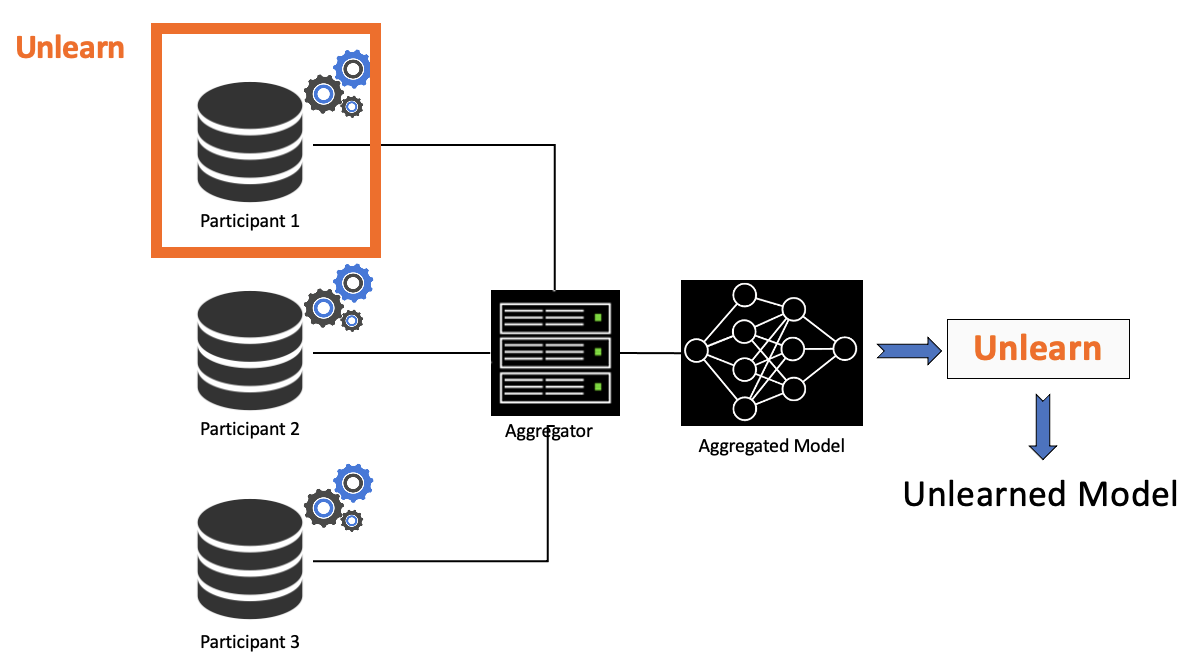

## Contents:

1. [Load prereqs and data](#section_1)
2. [Load data and backdoor a given percentage of the data of the target client](#section_2)
3. [Train the FL Model](#section_3)
4. [Unlearn the contribution of the target client](#section_4)
5. [Post-Training](#section_5)

## 1. Load prereqs 
<a id='section_1'></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import copy
import itertools
import math

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

#seeds
torch.manual_seed(0)
np.random.seed(0)

In [2]:
from backpack import backpack, extend
from backpack.extensions import DiagHessian

#### FL Fusion Class Selection

In [3]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties), 
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [4]:
num_parties = 5
scale = 1
# Currently, we assume that the party to be erased is party_id = 0
party_to_be_erased = 0
num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data and backdoor a given percentage of the data of the target client
<a id='section_2'></a>

**Note:** We use the backdoor triggers (Gu et al., 2017) as an effective way to evaluate the performance of unlearning methods. In particular, the target client uses a dataset with a certain fraction of images which have a backdoor trigger inserted in them. Thus, the global FL model becomes susceptible to the backdoor trigger. Then, a successful unlearning process should produce a model that reduces the accuracy on the images with the backdoor trigger, while
maintaining a good performance on regular (clean) images. Note that we use the backdoor triggers as a way to evaluate the performance of unlearning methods; we do not consider any malicious client.

Load ART

In [5]:
import numpy as np
import art
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical

Load MNIST from ART

In [6]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train_party = x_train[0:num_samples_erased_party]
y_train_party = y_train[0:num_samples_erased_party]

Initialize Backdoor Pattern

In [7]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Insert Backdoor

In [8]:
percent_poison = .8

all_indices = np.arange(len(x_train_party))
remove_indices = all_indices[np.all(y_train_party == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
num_poison = int(percent_poison * len(target_indices))
print(f'num poison: {num_poison}')
selected_indices = np.random.choice(target_indices, num_poison, replace=False)

poisoned_data, poisoned_labels = backdoor.poison(x_train_party[selected_indices], y=example_target, broadcast=True)

poisoned_x_train = np.copy(x_train_party)
poisoned_y_train = np.argmax(y_train_party,axis=1)
for s,i in zip(selected_indices,range(len(selected_indices))):
    poisoned_x_train[s] = poisoned_data[i]
    poisoned_y_train[s] = int(np.argmax(poisoned_labels[i]))

num poison: 8636


9


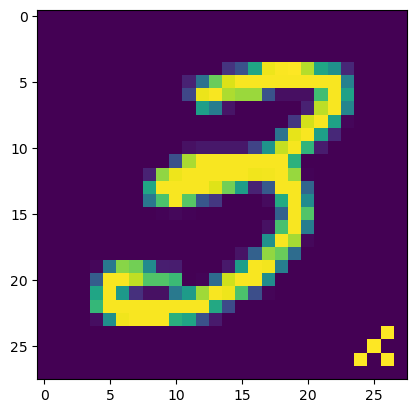

In [9]:
import matplotlib.pyplot as plt
plt.imshow(poisoned_x_train[selected_indices[0]])
print(poisoned_y_train[0])

Create PyTorch dataset from poisoned data

In [10]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

poisoned_x_train_ch = np.expand_dims(poisoned_x_train, axis = 1)
print('poisoned_x_train_ch.shape:',poisoned_x_train_ch.shape)
print('poisoned_y_train.shape:',poisoned_y_train.shape)
poisoned_dataset_train = TensorDataset(torch.Tensor(poisoned_x_train_ch),torch.Tensor(poisoned_y_train).long())
poisoned_dataloader_train = DataLoader(poisoned_dataset_train, batch_size=128, shuffle=True)

poisoned_x_train_ch.shape: (12000, 1, 28, 28)
poisoned_y_train.shape: (12000,)


Create PyTorch datasets for other parties

In [11]:
num_samples = (num_parties - 1) * num_samples_per_party
x_train_parties = x_train[num_samples_erased_party:num_samples_erased_party+num_samples] 
x_train_parties_ch = np.expand_dims(x_train_parties, axis=1)
y_train_parties = y_train[num_samples_erased_party:num_samples_erased_party+num_samples]
y_train_parties_c = np.argmax(y_train_parties, axis=1).astype(int)
print(x_train_parties_ch.shape)
print(y_train_parties_c.shape)

x_train_parties = TensorDataset(torch.Tensor(x_train_parties_ch), torch.Tensor(y_train_parties_c).long())
clean_dataset_train = torch.utils.data.random_split(x_train_parties, [num_samples_per_party for _ in range(1, num_parties)])

trainloader_lst = [poisoned_dataloader_train] 
for i in range(len(clean_dataset_train)):
    trainloader_lst.append(DataLoader(clean_dataset_train[i], batch_size=128, shuffle=True))

(48000, 1, 28, 28)
(48000,)


Create test dataloaders

In [12]:
all_indices = np.arange(len(x_test))
remove_indices = all_indices[np.all(y_test == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
print('num poison test:', len(target_indices))
poisoned_data, poisoned_labels = backdoor.poison(x_test[target_indices], y=example_target, broadcast=True)

poisoned_x_test = np.copy(x_test)
poisoned_y_test = np.argmax(y_test,axis=1)

for s,i in zip(target_indices,range(len(target_indices))):
    poisoned_x_test[s] = poisoned_data[i]
    poisoned_y_test[s] = int(np.argmax(poisoned_labels[i]))

poisoned_x_test_ch = np.expand_dims(poisoned_x_test, axis = 1)
print(poisoned_x_test_ch.shape)
print(poisoned_y_test.shape)
poisoned_dataset_test = TensorDataset(torch.Tensor(poisoned_x_test_ch),torch.Tensor(poisoned_y_test).long())
testloader_poison = DataLoader(poisoned_dataset_test, batch_size=1000, shuffle=False)

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
print(x_test_pt.shape)
print(y_test_pt.shape)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

num poison test: 8991
(10000, 1, 28, 28)
(10000,)
(10000, 1, 28, 28)
(10000,)


In [13]:
import random

poisoned_indices = target_indices  # These are the indices that were poisoned (8991 samples)

# Randomly select 5000 poisoned samples
sampled_poisoned_indices = random.sample(poisoned_indices, 4500)

# Extract the poisoned data
sampled_poisoned_x = np.array([poisoned_x_test_ch[i] for i in sampled_poisoned_indices])
sampled_poisoned_y = np.array([poisoned_y_test[i] for i in sampled_poisoned_indices])

# For clean samples, randomly select 5000 from the original x_test
# First expand dimensions to match the format of poisoned data
x_test_expanded = np.expand_dims(x_test, axis=1)

# Randomly select 5000 indices for clean samples
all_indices = np.arange(len(x_test))
sampled_clean_indices = random.sample(list(all_indices), 5500)

# Extract the clean data
sampled_clean_x = x_test_expanded[sampled_clean_indices]
# Use original labels from y_test (before poisoning)
sampled_clean_y = np.argmax(y_test[sampled_clean_indices], axis=1)

# Combine poisoned and clean samples
balanced_x = np.concatenate([sampled_poisoned_x, sampled_clean_x], axis=0)
balanced_y = np.concatenate([sampled_poisoned_y, sampled_clean_y], axis=0)

# Create the balanced dataset and dataloader
balanced_dataset = TensorDataset(torch.Tensor(balanced_x), torch.Tensor(balanced_y).long())
balanced_loader = DataLoader(balanced_dataset, batch_size=1000, shuffle=True)

print(f"Created balanced loader with {len(balanced_x)} samples total")
print(f"Poisoned samples: {len(sampled_poisoned_x)}, Clean samples: {len(sampled_clean_x)}")

Created balanced loader with 10000 samples total
Poisoned samples: 4500, Clean samples: 5500


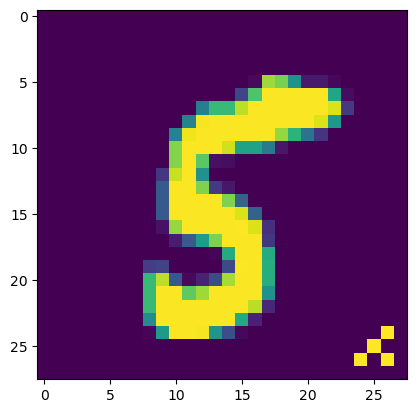

In [14]:
plt.imshow(balanced_x[0,0])

## 3. Train the FL Model
<a id='section_3'></a>

In [58]:
num_of_repeats = 1
num_fl_rounds = 50

fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1 

dist_Retrain = {}
loss_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [59]:
party_models_dict = {}


class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

initial_model = FLNet2()
model_dict = {}
for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds): 
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        current_model = copy.deepcopy(initial_model)
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(num_parties):

            if fusion_key == 'Retrain' and party_id == party_to_be_erased:
                party_models.append(FLNet2())
            else:
                model = copy.deepcopy(current_model)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = "cpu",
                                            criterion=None, opt=None)

                party_models.append(copy.deepcopy(model_update))
                party_losses.append(party_loss)

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)

        model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet2()
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')
        pois_acc = Utils.evaluate(testloader_poison, eval_model)
        pois_accuracy[fusion_key][round_num] = pois_acc
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {pois_acc}')

Global Clean Accuracy FedAvg, round 0 = 70.92
Global Backdoor Accuracy FedAvg, round 0 = 40.48
Global Clean Accuracy FedAvg, round 1 = 92.52
Global Backdoor Accuracy FedAvg, round 1 = 16.96
Global Clean Accuracy FedAvg, round 2 = 95.01
Global Backdoor Accuracy FedAvg, round 2 = 21.54
Global Clean Accuracy FedAvg, round 3 = 96.31
Global Backdoor Accuracy FedAvg, round 3 = 25.01
Global Clean Accuracy FedAvg, round 4 = 96.82
Global Backdoor Accuracy FedAvg, round 4 = 38.91
Global Clean Accuracy FedAvg, round 5 = 97.56
Global Backdoor Accuracy FedAvg, round 5 = 46.2
Global Clean Accuracy FedAvg, round 6 = 97.73
Global Backdoor Accuracy FedAvg, round 6 = 64.12
Global Clean Accuracy FedAvg, round 7 = 97.82
Global Backdoor Accuracy FedAvg, round 7 = 77.47
Global Clean Accuracy FedAvg, round 8 = 98.0
Global Backdoor Accuracy FedAvg, round 8 = 84.71
Global Clean Accuracy FedAvg, round 9 = 98.17
Global Backdoor Accuracy FedAvg, round 9 = 86.93
Global Clean Accuracy FedAvg, round 10 = 98.16
Globa

In [60]:
torch.save(model.state_dict(), "poison_model")

In [61]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian(dataloader_list, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Store Hessians and batch counts per client
    client_hessians = []
    total_batches = 0

    # Calculate diagonal Hessian for each client
    for loader_idx, loader in enumerate(dataloader_list):
        accumulated_diag_h = {}
        print(f"Calculating diagonal Hessian for client {loader_idx}")
        
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute diagonal Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)
            
            # Accumulate values
            for name, value in diag_h.items():
                if name not in accumulated_diag_h:
                    accumulated_diag_h[name] = value
                else:
                    accumulated_diag_h[name] += value
            
            total_batches += 1
        
        # Store results for this client
        client_hessians.append(accumulated_diag_h)


    # Normalize client importance weights
    if weights is None:
        weights = [1.0] * len(dataloader_list)

    # Weighted average of client Hessians
    weighted_avg_hessian = {}
    for name in client_hessians[0].keys():
        weighted_avg_hessian[name] = sum(
            client_hessians[i][name] * weights[i] for i in range(len(client_hessians))
        ) / total_batches
    
    return weighted_avg_hessian

In [62]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

final_model = FLNet2()
final_model.load_state_dict(current_model_state_dict)

final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.01

# Create weights list
weights = [1] * len(trainloader_list)
weights[party_to_be_erased] = 1 - delta

weights=torch.tensor(weights, dtype=torch.float32)

weights_half = weights
weights_half[party_to_be_erased] = 1 - delta / 2

accumulated_diag_h = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion)
accumulated_diag_h_removed = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights)

Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4
Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4


In [63]:
def compute_true_info(hessian, hessian_delta, delta):
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
        print(k)

        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        ratio = hessian_delta[k]/hessian[k]
        A=1/2 * torch.log(ratio)/delta
        B=1/2 * (1-ratio)/delta

        A[degeneracies_indices]=0
        B[degeneracies_indices]=0

        assert torch.sum(torch.isnan(A))==0, f"NaN values in A: {torch.sum(torch.isnan(A))}"
        assert torch.sum(torch.isnan(B))==0, f"NaN values in B: {torch.sum(torch.isnan(B))}"
        assert torch.sum(torch.isinf(A))==0, f"Inf values in A: {torch.sum(torch.isinf(A))}"
        assert torch.sum(torch.isinf(B))==0, f"Inf values in B: {torch.sum(torch.isinf(B))}"

        A_list[i]=A
        B_list[i]=B

    C = sum([torch.sum(A_list[i]+B_list[i]).item() for i in range(len(A_list))])

    information_true=[(A_list[i]+B_list[i])*C + 2*torch.pow(B_list[i],2) for i in range(len(hessian.keys()))]

    return information_true
def compute_second_deriv_info(hessian, hessian_half_delta, hessian_delta, delta):
    information = []
    for k in hessian.keys(): 
        print(k)
        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        degeneracies_indices = torch.logical_or(degeneracies_indices, torch.pow(hessian_half_delta[k],2)==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        A=1/2 * torch.log(hessian_delta[k]*hessian[k]/torch.pow(hessian_half_delta[k],2))
        #plt.plot(A.cpu().flatten(), label=k+'A')
        B=1/2 * (2*hessian_half_delta[k]/hessian[k]-hessian_delta[k]/hessian[k] -1)
        print(np.var(B.cpu().flatten().numpy()))
        print(np.mean(B.cpu().flatten().numpy()))
        #plt.plot(B.cpu().flatten(), label=k+'B')

        #plt.legend()
        #plt.show()

        I=-(A+B)/((delta/2)**2)

        I[degeneracies_indices]=0

        assert torch.sum(torch.isnan(I))==0, f"NaN values in {k}: {torch.sum(torch.isnan(I))}"
        assert torch.sum(torch.isinf(I))==0, f"Inf values in {k}: {torch.sum(torch.isinf(I))}"

        information.append(I)

    return information

def delta_hessian(hessian, hessian_delta, delta):
    delta_hessian = []
    for k in hessian.keys():
        delta_hessian.append(torch.abs(hessian_delta[k] - hessian[k]) / delta)
    return delta_hessian

device = 'cuda' if torch.cuda.is_available() else 'cpu'
info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor([1]).to(device))

0.weight
Number of degenaracies: 0
0.bias
Number of degenaracies: 0
3.weight
Number of degenaracies: 0
3.bias
Number of degenaracies: 0
7.weight
Number of degenaracies: 7352
7.bias
Number of degenaracies: 0
9.weight
Number of degenaracies: 0
9.bias
Number of degenaracies: 0


1638789
Number of outliers: 32776


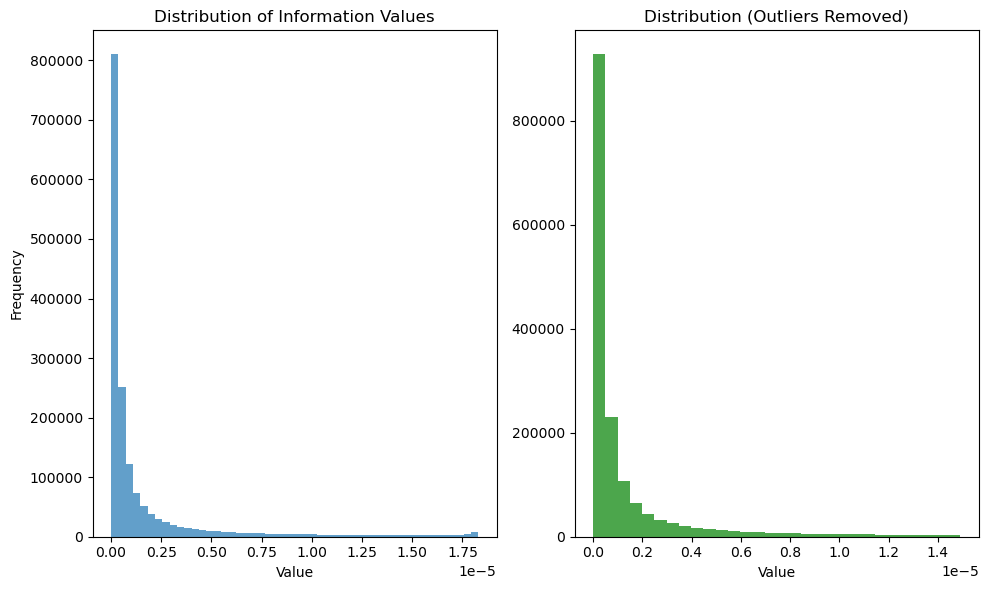

Sum of all information values: 2.693972
Mean: 1.643879727453168e-06
Min: 1.7763568394002505e-15
Max: 1.8288650608155876e-05
Total number of values: 1638789
Sum of all information values: 2.139559
Mean: 1.3322179484021035e-06
Min: 1.7763568394002505e-15
Max: 1.4922983609721996e-05
Total number of values: 1606013


(2.693972110748291, 2.139559268951416)

In [64]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

plot_information(info_true)

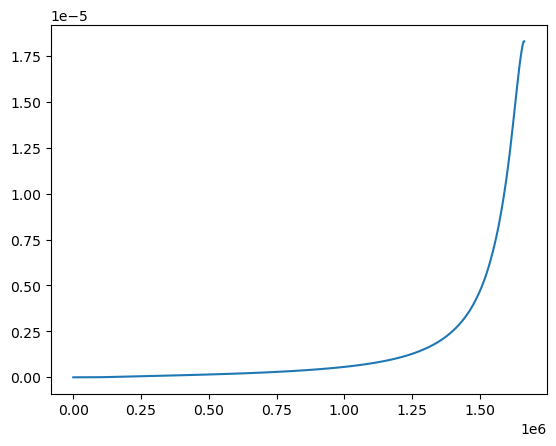

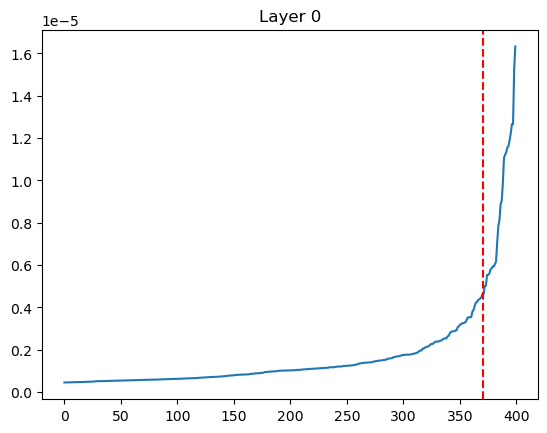

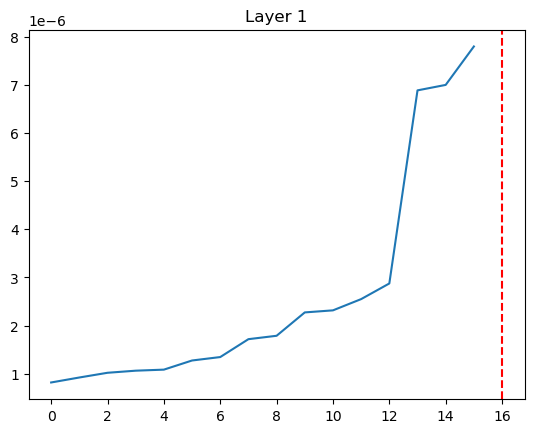

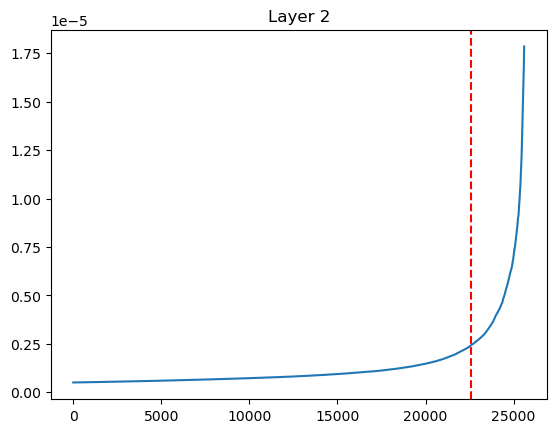

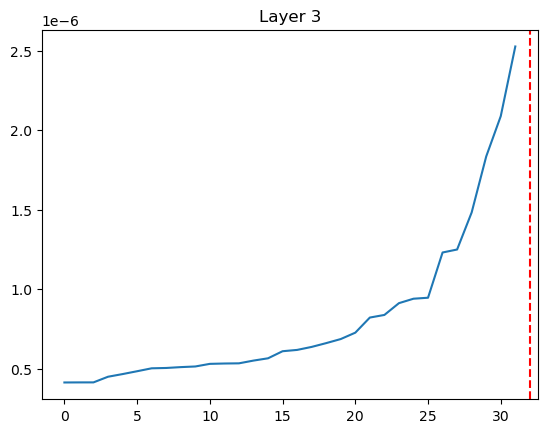

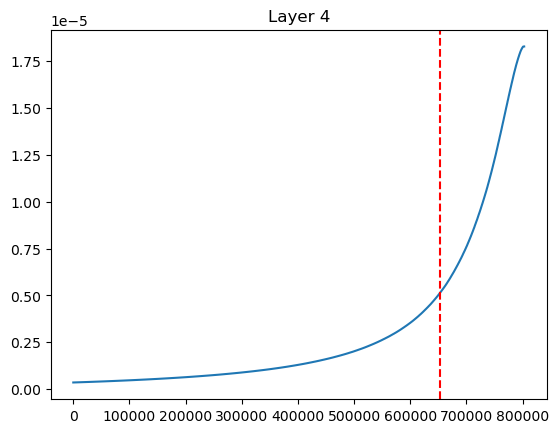

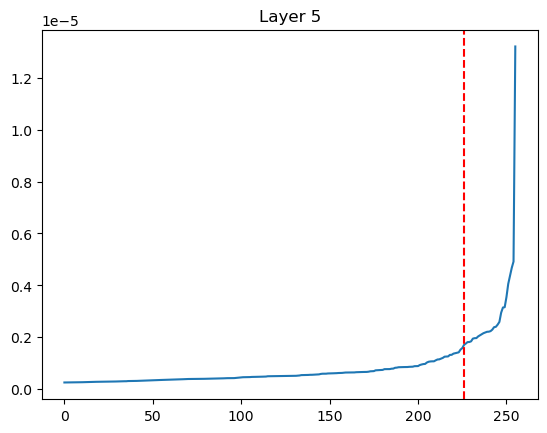

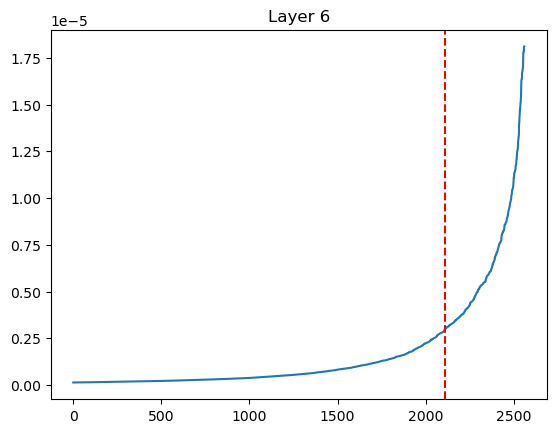

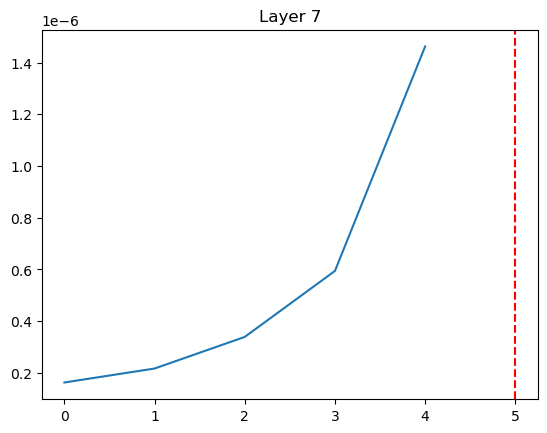

In [ ]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))

s_infolayers = [np.sort(p.cpu().flatten()) for p in info_true]

#Find elbow
# from kneed import KneeLocator
# kl = KneeLocator(range(len(s_infocat)), s_infocat, curve='convex', direction='increasing')
# #kl.plot_knee()
# informative_params = len(s_infocat)-kl.knee
# print(f"Number of informative parameters: {informative_params}")

# n=40 # print the last n*informative_params parameters
#plt.plot(s_infocat[-informative_params*n:])
plt.plot(s_infocat)
##Plot the knee
#plt.axvline(informative_params*(n-1), color='red', linestyle='--')
plt.show()

auto_idx_tresholds = [int(len(s_infolayers[i])*0.5) for i in range(len(s_infolayers))]

custom_thresholds = [-3, 0, -200, 0, -10000, -2, -30, 0]

custom_thresholds = [a*15 for a in custom_thresholds]

for i in range(len(s_infolayers)):
    plt.plot(s_infolayers[i][auto_idx_tresholds[i]:])
    plt.axvline(len(s_infolayers[i])-auto_idx_tresholds[i]+custom_thresholds[i], color='red', linestyle='--')
    plt.title(f'Layer {i}')
    plt.show()


In [83]:
final_model = FLNet2()
final_model.load_state_dict(torch.load("poison_model", weights_only=True))

<All keys matched successfully>

In [84]:
tresholds = [p[custom_thresholds[i]] for i,p in enumerate(s_infolayers)]
retrain_param_indices = []
for i, p in enumerate(info_true):
    if custom_thresholds[i] != 0:
        indices = torch.argwhere(p > tresholds[i])
        retrain_param_indices.append(indices)
    else:
        retrain_param_indices.append(torch.empty(size=[0 for _ in range(p.dim())]))

model_reset = copy.deepcopy(final_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)

unlearn_clean_acc = Utils.evaluate(testloader_poison, final_model)
print(f'Poison for Reference Model = {unlearn_clean_acc}')
unlearn_pois_acc = Utils.evaluate(testloader_poison, model_reset)
print(f'Poison Accuracy for Reset Model = {unlearn_pois_acc}')

Poison for Reference Model = 99.24
Poison Accuracy for Reset Model = 6.04


In [85]:
class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    
    def get_retrained_params(self):
        """
        Returns the retrained parameters of the model.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )
        
        detached_params = {}
        for key, value in final_params.items():
            detached_params[key] = value.cpu().detach()
        return detached_params
    
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

unlearn_clean_acc = Utils.evaluate(testloader_poison, final_model)
print(f'Poison for Reference Model = {unlearn_clean_acc}')
unlearn_pois_acc = Utils.evaluate(testloader_poison, unlearn_model)
print(f'Poison Accuracy for Unlearned Model = {unlearn_pois_acc}')

unlearn_clean_acc = Utils.evaluate(testloader, final_model)
print(f'Accuracy on True Dataset for Reference Model = {unlearn_clean_acc}')
unlearn_pois_acc = Utils.evaluate(testloader, unlearn_model)
print(f'Accuracy on True Dataset for Unlearned Model = {unlearn_pois_acc}')

Poison for Reference Model = 99.24
Poison Accuracy for Unlearned Model = 6.22
Accuracy on True Dataset for Reference Model = 98.8
Accuracy on True Dataset for Unlearned Model = 95.3


In [86]:
num_of_repeats = 1
num_fl_rounds = 5

fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
parties = list(range(len(num_parties)))
del parties[party_to_be_erased]

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=len(parties), fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in parties:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')
        pois_acc = Utils.evaluate(testloader_poison, eval_model)
        pois_accuracy[fusion_key][round_num] = pois_acc
        print(f'Global Poison Accuracy {fusion_key}, round {round_num} = {pois_acc}')

Training party 1
Training party 2
Training party 3
Training party 4
Global Clean Accuracy FedAvg, round 0 = 98.93
Global Poison Accuracy FedAvg, round 0 = 10.29
Training party 1
Training party 2
Training party 3
Training party 4
Global Clean Accuracy FedAvg, round 1 = 98.93
Global Poison Accuracy FedAvg, round 1 = 10.34
Training party 1
Training party 2
Training party 3
Training party 4
Global Clean Accuracy FedAvg, round 2 = 98.92
Global Poison Accuracy FedAvg, round 2 = 10.3
Training party 1
Training party 2
Training party 3
Training party 4
Global Clean Accuracy FedAvg, round 3 = 98.93
Global Poison Accuracy FedAvg, round 3 = 10.27
Training party 1
Training party 2
Training party 3
Training party 4
Global Clean Accuracy FedAvg, round 4 = 98.92
Global Poison Accuracy FedAvg, round 4 = 10.32


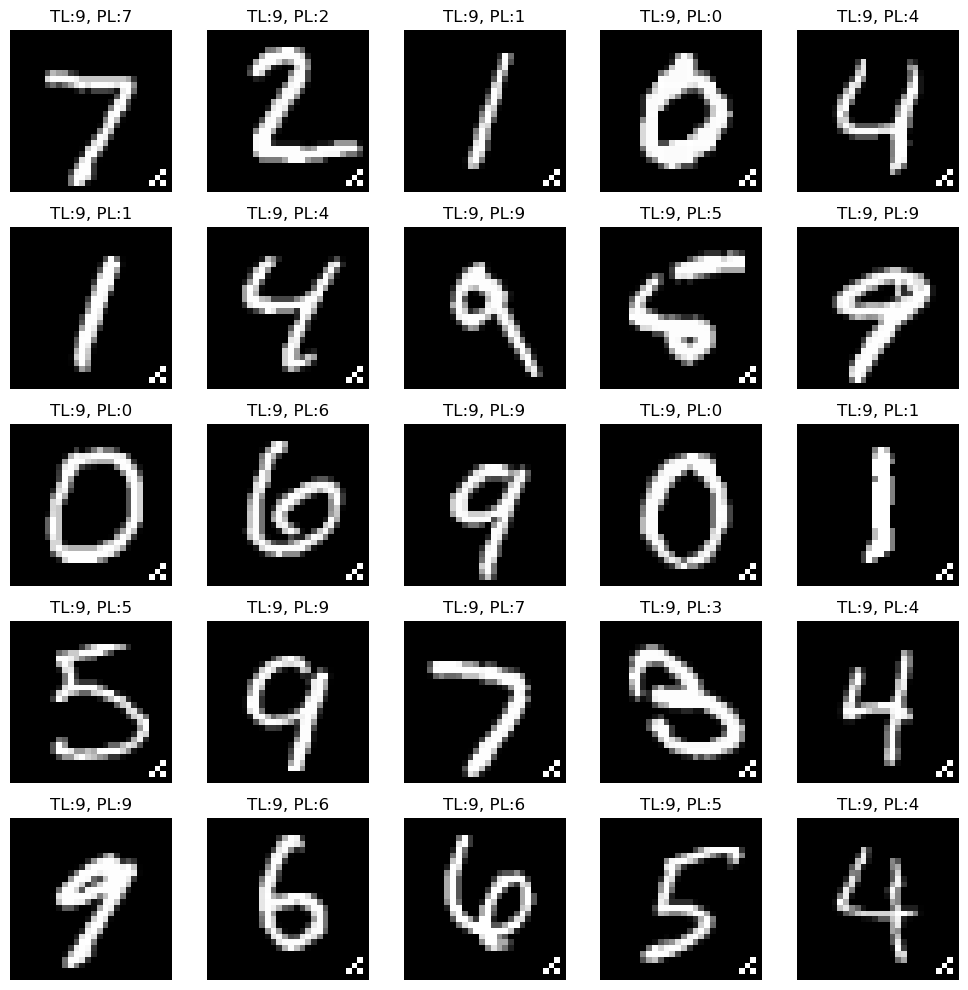

In [ ]:
#dataloader_prova = testloader_poison[0]  # Using the first party's dataloader
images, labels = next(iter(testloader_poison))

def show_mnist_images(images, labels, num_images=25):
    n = min(num_images, len(images))
    
    grid_size = int(np.ceil(np.sqrt(n)))
    
    plt.figure(figsize=(10, 10))
    for i in range(n):
        outputs = eval_model(images[i].unsqueeze(dim = 0))
        _, predicted = torch.max(outputs.data, 1)
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f"TL:{labels[i].item()}, PL:{predicted[0]}")
    
    plt.tight_layout()
    plt.show()

show_mnist_images(images, labels)